## Random Forest Regressor

A Random Forest Regressor is an ensemble of decision tree regressors. The output of a random forest regressor would be the average (weighted if some trees hold more significance) from the trees. RFR can perform better than singular decision tree because it allows the trees to explore different paths and extract various insights.

The output of a random forest regressor would be the average from the trees. Each Tree randomly samples the features at each node.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.datasets import load_diabetes

In [ ]:
class Node:

        def __init__(self, left, right, feature, threshold, avg_target, sse=0):
            
            self.left = left
            self.right = right
            self.feature = feature
            self.threshold = threshold
            self.avg_target = avg_target
            self.sse = sse


class RegressionDecisionTree:

    def __init__(self, min_samples=5, max_depth=3, max_features=3):

        self.min_samples = min_samples if min_samples > 0 else 5
        self.max_depth = max_depth if max_depth > 1 else 3
        self.max_features = max_features if max_features >= 1 else 3
        self.root = None
    
    def get_sse(self, subset, target_col):

        return sum((subset[target_col] - subset[target_col].mean())**2)

    
    def fit(self, data, target_col):

        self.root = self._fit(0, data, target_col, float("inf"))
    
    def _fit(self, depth, data, target_col, parent_sse):
         
        if len(data) < self.min_samples or depth >= self.max_depth:
             
            return Node(None, None, None, None, data[target_col].mean())

        features = np.random.choice([f for f in data if f != target_col], size=self.max_features, replace=False)

        best_feat, best_split, best_sse = None, None, parent_sse

        for feat in features:
             
            sorted_data = data.sort_values(by=[feat], ascending=True)
            uniques = np.unique(sorted_data[feat])


            for i in range(1, len(uniques)):

                split = (uniques[i-1] + uniques[i]) / 2

                left_region = data[data[feat] < split]
                right_region = data[data[feat] >= split]

                total_sse = self.get_sse(left_region, target_col) + self.get_sse(right_region, target_col)

                if total_sse < best_sse:

                    best_feat, best_split = feat, split
                    best_sse = total_sse
        
        if not best_feat:

            return Node(None, None, None, None, data[target_col].mean())

        node = Node(None, None, best_feat, best_split, data[target_col].mean(), best_sse)
        print(f"Node best feat: {node.feature}, Node best split: {node.threshold}, Node average target: {node.avg_target}, Node best sse: {best_sse}")
        node.left = self._fit(depth+1, data[data[best_feat] < best_split], target_col, best_sse)
        node.right = self._fit(depth+1, data[data[best_feat] >= best_split], target_col, best_sse)
        return node

    def predict(self, data):

        preds = [self._predict(row[1]) for row in data.iterrows()]
        return np.array(preds)

    
    def _predict(self, obs):

        curr = self.root

        while curr.left and curr.right:

            feat, split = curr.feature, curr.threshold

            if obs[feat] < split:

                curr = curr.left
            
            else:

                curr = curr.right
        
        return curr.avg_target

class RandomForestRegressor:

    def __init__(self, num_trees=3, max_depth=3, min_samples=5, max_features=3):

        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.max_features = max_features
        self.trees = {}
    
    def fit(self, data, target_col):

        for k in range(self.num_trees):

            temp_data = data.sample(n=len(data), replace=True)

            temp_data.reset_index(drop=True, inplace=True)

            dc = RegressionDecisionTree(min_samples=self.min_samples, max_depth=self.max_depth)

            dc.fit(temp_data, target_col)

            tree_cols = [col for col in temp_data.columns if col != target_col]

            self.trees[f"decision_tree_{k+1}"] = {"Features": tree_cols, "Max Depth": self.max_depth,
                                                  "Min Samples Split": self.min_samples,
                                                    "Fitted Model": dc}
    
    def predict(self, data):

        predictions = np.zeros(len(data))

        for dc in self.trees.values():
            
            tree = dc["Fitted Model"]

            pred = tree.predict(data)

            predictions += pred

        
        return predictions * (1/self.num_trees)

    def get_feature_importances(self):

        if not self.trees:

            print("Tree Not Fitted")

            return
        
        trees = [t["Fitted Model"] for t in self.trees.values()]

        data_columns = list(self.trees.values())[0]["Features"]

        return self._get_feature_importances(trees, data_columns)
    
    def _get_feature_importances(self, trees, cols):

        trees_feat_imps = []

        total_reduction = 0

        for tree in trees:

            feat_imp = {col:0 for col in cols}

            stack = [tree.root]

            while stack:

                parent = stack.pop()
                left_c, right_c = parent.left, parent.right

                if left_c and left_c.feature:
                    
                    stack.append(left_c)
                    feat_imp[left_c.feature] += parent.sse - left_c.sse
                
                if right_c and right_c.feature:

                    stack.append(right_c)
                    feat_imp[right_c.feature] += parent.sse - right_c.sse
                
            
            total_reduction += sum(list(feat_imp.values()))

            trees_feat_imps.append(feat_imp)

        
        avg_feat_imps = {}

        for col in cols:

            trees_col_imps = [tree_imp[col] for tree_imp in trees_feat_imps]

            avg_feat_imps[col] = (sum(trees_col_imps) / len(trees_col_imps)) * 1/total_reduction

        
        
        return pd.Series(index=list(avg_feat_imps.keys()), data=list(avg_feat_imps.values()), name="Feature Importances").sort_values(ascending=True)

            








In [50]:
def mse(y_true, y_hat):

    return np.mean((y_true - y_hat)**2)

def rmse(y_true, y_hat):

    return np.sqrt(np.mean((y_true - y_hat)**2))

In [51]:
np.random.seed(42)

diabetes = load_diabetes(as_frame=True, scaled=False)
target_col = "target"

data = diabetes["data"]
data = pd.concat([data, diabetes[target_col]], axis=1)
data

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


In [52]:
train_size = 0.8

train_data = data[:int(len(data)*train_size)]
test_data = data[int(len(data)*train_size):]

In [53]:
num_trees, max_depth, min_samples, max_features = 20, 3, 5, 3

my_rfr = RandomForestRegressor(num_trees=num_trees, min_samples=min_samples, max_depth=max_depth, max_features=max_features)
my_rfr.fit(train_data, target_col)

sklearn_rdt = RFR(n_estimators=num_trees, max_depth=max_depth, min_samples_split=min_samples)
y = train_data[target_col]
X = train_data.drop(columns=target_col)
y_test = test_data[target_col]
X_test = test_data.drop(columns=target_col)
sklearn_rdt.fit(X, y)

Node best feat: bp, Node best split: 101.5, Node average target: 153.3484419263456, Node best sse: 1657484.902572965
Node best feat: s6, Node best split: 89.5, Node average target: 132.29435483870967, Node best sse: 877802.4380516508
Node best feat: s4, Node best split: 4.5, Node average target: 106.34586466165413, Node best sse: 279609.07692307676
Node best feat: s5, Node best split: 5.1555, Node average target: 162.30434782608697, Node best sse: 469087.5622347951
Node best feat: s5, Node best split: 4.8553, Node average target: 203.07619047619048, Node best sse: 457809.830322074
Node best feat: s4, Node best split: 5.5, Node average target: 156.57894736842104, Node best sse: 152437.23529411762
Node best feat: s2, Node best split: 146.8, Node average target: 229.44776119402985, Node best sse: 199702.1825980392
Node best feat: s5, Node best split: 4.879, Node average target: 154.78470254957506, Node best sse: 1475958.0899472914
Node best feat: s5, Node best split: 4.2836, Node average 

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",20
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at

In [54]:
rfr_preds = my_rfr.predict(test_data)
sklearn_preds = sklearn_rdt.predict(X_test)

pd.DataFrame(data={"Mean squared Error": [mse(test_data[target_col], rfr_preds), mse(y_test, sklearn_preds)] ,
                    "Root Mean Squared Error": [rmse(test_data[target_col], rfr_preds), rmse(y_test, sklearn_preds)]}, index=["My RFR", "SKlearn RFR"])



,Mean squared Error,Root Mean Squared Error
My RFR,3523.580657,59.359756
SKlearn RFR,3369.293897,58.045619


<Axes: title={'center': 'Feature Importances'}>

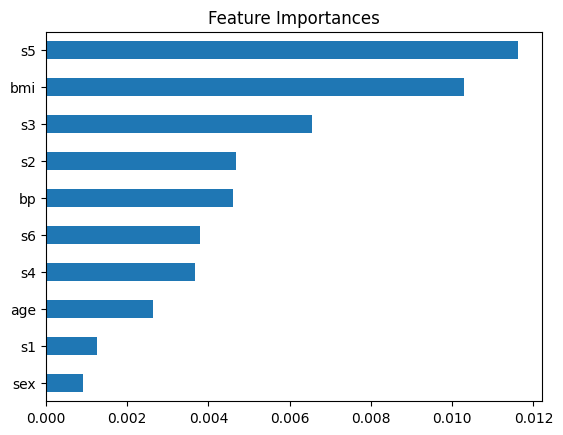

In [55]:
feat_imp = my_rfr.get_feature_importances()
feat_imp.plot(kind="barh", title="Feature Importances")

<Axes: title={'center': 'Sklearn Feature Importances'}>

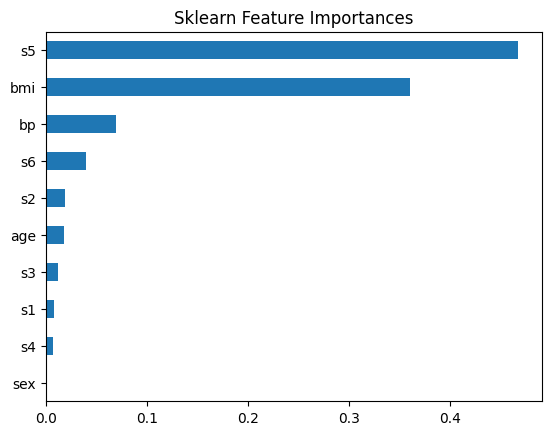

In [ ]:
pd.Series(index=sklearn_rdt.feature_names_in_, data=sklearn_rdt.feature_importances_).\
sort_values(ascending=True).\
plot(kind="barh", title="Sklearn Feature Importances")